# 📈 Model Evaluation Notebook — ML vs Rule-Based

## 1. Setup

In [2]:

import sys
from pathlib import Path

# Add project root to path for relative imports
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Paths
MODEL_PATH = "../models/trained_from_rule_labels.pkl"
TRADES_PATH = "../results/batch_backtest_results.csv"
TOP_CONFIGS_PATH = "../configs/top_10_configs.json"

# Load model
model = joblib.load(MODEL_PATH)
print("✅ Model loaded")


✅ Model loaded


## 2. Load & Prepare Evaluation Data

In [3]:

import json
with open(TOP_CONFIGS_PATH) as f:
    top_config_ids = [cfg["Config_ID"] for cfg in json.load(f)]

# Reload labeled dataset
all_trades = pd.read_csv(TRADES_PATH, parse_dates=["Entry Date", "Exit Date"])
all_trades["Reversal"] = all_trades["Config_ID"].apply(lambda x: 1 if x in top_config_ids else 0)

from src.utils import load_csv, compute_keltner
from src.features import build_feature_matrix

WEEKLY_DIR = Path("../stock_historical_information/weekly")

all_X = []
all_y = []

for ticker in all_trades["Ticker"].unique():
    try:
        file = WEEKLY_DIR / f"{ticker}_weekly.csv"
        df = load_csv(file)
        df = compute_keltner(df)
        df.index = pd.to_datetime(df.index)

        events = all_trades[all_trades["Ticker"] == ticker]
        X, y = build_feature_matrix(events, df)

        if len(X) > 0:
            all_X.append(X)
            all_y.append(y)
    except Exception as e:
        print(f"⚠️  {ticker} skipped —", e)

X_all = pd.concat(all_X)
y_all = pd.concat(all_y)

print(f"📊 Final evaluation dataset: {X_all.shape}")


📊 Final evaluation dataset: (16716, 11)


## 3. Predict and Evaluate

🔍 Classification Report
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     14624
           1       0.14      0.36      0.21      2092

    accuracy                           0.65     16716
   macro avg       0.51      0.53      0.49     16716
weighted avg       0.79      0.65      0.70     16716



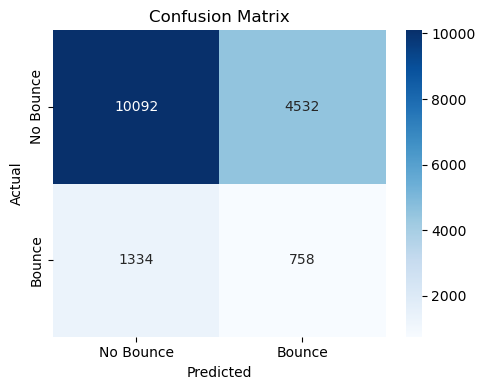

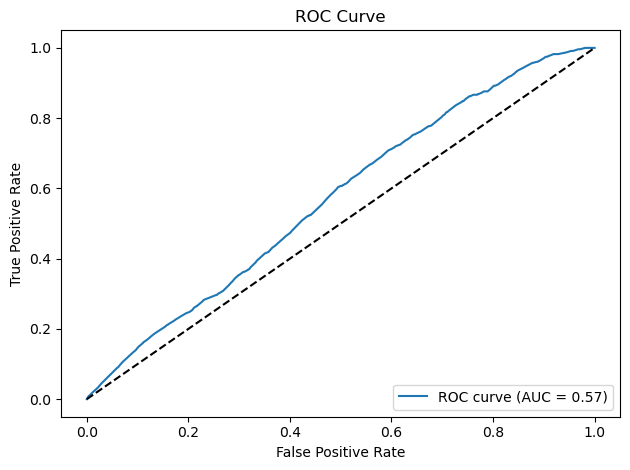

In [4]:

y_pred = model.predict(X_all)
y_prob = model.predict_proba(X_all)[:, 1]

# Classification report
print("🔍 Classification Report")
print(classification_report(y_all, y_pred))

# Confusion matrix
cm = confusion_matrix(y_all, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Bounce","Bounce"], yticklabels=["No Bounce","Bounce"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_all, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
